In [103]:
from pybaseball import schedule_and_record
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import *

from sklearn.metrics import (
    auc,
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_curve,
)

In [104]:
teams = ['MIN','CLE','KCR','CHW','DET', #AL Cenntral
         'TOR','BAL','BOS','TBR','NYY', #AL East
         'OAK','HOU','SEA','LAA','TEX', #AL West
         'ATL','PHI','NYM','WSN','MIA','FLA', #NL East
         'PIT','CIN','CHC','MIL','STL', #NL Central
         'ARI','SDP','SFG','COL','LAD', #NL West
        ]

years = np.arange(2009,2021,1)

full_games = pd.DataFrame()

for team in teams:
    print('Importing', team)
    for year in years:
        try:
            data = schedule_and_record(year, team)
            data['season'] = year
            full_games = pd.concat([full_games,data])
        except:
            continue
            
print('\nAll Teams Imported')

Importing MIN
Importing CLE
Importing KCR
Importing CHW
Importing DET
Importing TOR
Importing BAL
Importing BOS
Importing TBR
Importing NYY
Importing OAK
Importing HOU
Importing SEA
Importing LAA
Importing TEX
Importing ATL
Importing PHI
Importing NYM
Importing WSN
Importing MIA
Importing FLA
Importing PIT
Importing CIN
Importing CHC
Importing MIL
Importing STL
Importing ARI
Importing SDP
Importing SFG
Importing COL
Importing LAD

All Teams Imported


In [105]:
full_games['Tm'][full_games['Tm'] == 'FLA'] = 'MIA'

/opt/miniconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [106]:
import os
os.chdir('/Users/andrew.green/Downloads/')
odds2010 = pd.read_csv('mlb_odds_2010.csv')
odds2011 = pd.read_csv('mlb_odds_2011.csv')
odds2012 = pd.read_csv('mlb_odds_2012.csv')
odds2013 = pd.read_csv('mlb_odds_2013.csv')
odds2014 = pd.read_csv('mlb_odds_2014.csv')
odds2015 = pd.read_csv('mlb_odds_2015.csv')
odds2016 = pd.read_csv('mlb_odds_2016.csv')
odds2017 = pd.read_csv('mlb_odds_2017.csv')
odds2018 = pd.read_csv('mlb_odds_2018.csv')
odds2019 = pd.read_csv('mlb_odds_2019_2.csv')
odds2020 = pd.read_csv('mlb_odds_2020.csv')

game_odds = pd.concat([odds2010
                      ,odds2011
                      ,odds2012
                      ,odds2013
                      ,odds2014
                      ,odds2015
                      ,odds2016
                      ,odds2017
                      ,odds2018
                      ,odds2019
                      ,odds2020],axis=0)
game_odds = game_odds[['Date','Team','Close']]

#converting the odds to win probabilities
game_odds['implied_odds'] = (abs(game_odds['Close']) / (abs(game_odds['Close']) + 100) ).where(
            game_odds["Close"] <0, (100 / (game_odds['Close'] + 100))
        )

#cleaning csv data to have the same team codes as the team data
#there is 1 game that gets lost in this process
game_odds['Team'] = game_odds['Team'].replace({'SFO':'SFG'
                                               ,'TAM':'TBR'
                                               ,'WAS':'WSN'
                                               ,'KAN':'KCR'
                                               ,'CUB':'CHC'
                                               ,'SDG':'SDP'
                                               ,'CWS':'CHW'
                                               ,'LOS':'LAD'
                                                })
game_odds

,Date,Team,Close,implied_odds
0,4/4/2010,NYY,-103.0,0.507389
1,4/4/2010,BOS,-117.0,0.539171
2,4/5/2010,PHI,-200.0,0.666667
3,4/5/2010,WSN,170.0,0.370370
4,4/5/2010,MIA,-112.0,0.528302
...,...,...,...,...
1895,10/24/2020,TBR,148.0,0.403226
1896,10/25/2020,LAD,-160.0,0.615385
1897,10/25/2020,TBR,150.0,0.400000
1898,10/27/2020,TBR,111.0,0.473934


In [107]:
full_games['month'] = full_games['Date'].replace(to_replace = ['Mar','Apr','May',"Jun","Jul",'Aug'
                                                  ,'Sep',"Oct",'Nov','Dec']
                                              ,value = [3,4,5,6,7,8,9,10,11,12]
                                            ,regex=True)

full_games['clean_date'] = full_games['month'].astype(str)+'/'+full_games['Date'].str[-2:].astype(str).replace(' ','',regex=True) + '/' + exp_df['season'].astype(str)


combined_game_data = full_games.merge(game_odds,
                              how="left",
                              left_on=[
                                    "Tm",
                                    "clean_date",
                                ],
                                right_on=["Team", "Date"],
                            )
combined_game_data

,Date_x,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,...,cLI,Streak,Orig. Scheduled,season,month,clean_date,Date_y,Team,Close,implied_odds
0,"Monday, Apr 6",MIN,Home,SEA,L,1.0,6.0,9.0,0-1,3.0,...,1.03,-1,None,2009,4,4/6/2009,NaN,NaN,NaN,NaN
1,"Tuesday, Apr 7",MIN,Home,SEA,W-wo,6.0,5.0,9.0,1-1,2.0,...,.96,1,None,2009,4,4/7/2009,NaN,NaN,NaN,NaN
2,"Wednesday, Apr 8",MIN,Home,SEA,W,6.0,5.0,9.0,2-1,1.0,...,.96,2,None,2009,4,4/8/2009,NaN,NaN,NaN,NaN
3,"Thursday, Apr 9",MIN,Home,SEA,L,0.0,2.0,9.0,2-2,2.0,...,1.05,-1,None,2009,4,4/9/2009,NaN,NaN,NaN,NaN
4,"Friday, Apr 10",MIN,@,CHW,W,12.0,5.0,9.0,3-2,1.0,...,1.15,1,None,2009,4,4/10/2009,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55258,"Wednesday, Sep 23",LAD,Home,OAK,L,4.0,6.0,9.0,39-17,1.0,...,.00,-1,None,2020,9,9/23/2020,9/23/2020,LAD,-164.0,0.621212
55259,"Thursday, Sep 24",LAD,Home,OAK,W,5.0,1.0,9.0,40-17,1.0,...,.01,1,None,2020,9,9/24/2020,9/24/2020,LAD,-220.0,0.687500
55260,"Friday, Sep 25",LAD,Home,LAA,W,9.0,5.0,9.0,41-17,1.0,...,.00,2,None,2020,9,9/25/2020,9/25/2020,LAD,-210.0,0.677419
55261,"Saturday, Sep 26",LAD,Home,LAA,W,7.0,6.0,9.0,42-17,1.0,...,.00,3,None,2020,9,9/26/2020,9/26/2020,LAD,-300.0,0.750000


In [108]:
#counting games to remove cold start
combined_game_data['teams_games'] = combined_game_data.groupby(
    (combined_game_data['Tm'] != combined_game_data['Tm'].shift(1)
    ).cumsum()).cumcount()+1

#calculating quality of the team going into that game
combined_game_data['R_FOR'] = combined_game_data['R'].rolling(min_periods=1, window=41).sum() - combined_game_data['R']
combined_game_data['R_AGAINST'] = combined_game_data['RA'].rolling(min_periods=1, window=41).sum() - combined_game_data['RA']
combined_game_data['PT'] = (combined_game_data['R_FOR'] **1.83) / (
    (combined_game_data['R_FOR'] **1.83) + (combined_game_data['R_AGAINST'] **1.83))


In [109]:
combined_game_data

,Date_x,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,...,month,clean_date,Date_y,Team,Close,implied_odds,teams_games,R_FOR,R_AGAINST,PT
0,"Monday, Apr 6",MIN,Home,SEA,L,1.0,6.0,9.0,0-1,3.0,...,4,4/6/2009,NaN,NaN,NaN,NaN,1,0.0,0.0,NaN
1,"Tuesday, Apr 7",MIN,Home,SEA,W-wo,6.0,5.0,9.0,1-1,2.0,...,4,4/7/2009,NaN,NaN,NaN,NaN,2,1.0,6.0,0.036301
2,"Wednesday, Apr 8",MIN,Home,SEA,W,6.0,5.0,9.0,2-1,1.0,...,4,4/8/2009,NaN,NaN,NaN,NaN,3,7.0,11.0,0.304252
3,"Thursday, Apr 9",MIN,Home,SEA,L,0.0,2.0,9.0,2-2,2.0,...,4,4/9/2009,NaN,NaN,NaN,NaN,4,13.0,16.0,0.406132
4,"Friday, Apr 10",MIN,@,CHW,W,12.0,5.0,9.0,3-2,1.0,...,4,4/10/2009,NaN,NaN,NaN,NaN,5,13.0,18.0,0.355369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55258,"Wednesday, Sep 23",LAD,Home,OAK,L,4.0,6.0,9.0,39-17,1.0,...,9,9/23/2020,9/23/2020,LAD,-164.0,0.621212,1840,238.0,151.0,0.696911
55259,"Thursday, Sep 24",LAD,Home,OAK,W,5.0,1.0,9.0,40-17,1.0,...,9,9/24/2020,9/24/2020,LAD,-220.0,0.687500,1841,236.0,155.0,0.683379
55260,"Friday, Sep 25",LAD,Home,LAA,W,9.0,5.0,9.0,41-17,1.0,...,9,9/25/2020,9/25/2020,LAD,-210.0,0.677419,1842,240.0,154.0,0.692524
55261,"Saturday, Sep 26",LAD,Home,LAA,W,7.0,6.0,9.0,42-17,1.0,...,9,9/26/2020,9/26/2020,LAD,-300.0,0.750000,1843,247.0,153.0,0.706092


In [113]:
#creating matchup probability to predict games
matchups = combined_game_data[['Tm','Opp','W/L','teams_games','PT','clean_date','season','implied_odds']]
print(matchups)
matchups = matchups.merge(matchups
                        , left_on=['Opp','clean_date','season']
                        , right_on=['Tm','clean_date','season']
                       ,suffixes=['_team','_opponent'])

#remove first 40 games in the dataset
matchups = matchups[(matchups['teams_games_team'] > 40) & (matchups['teams_games_opponent'] > 40)]
matchups = matchups[['Tm_team','Opp_team','W/L_team','PT_team','PT_opponent','implied_odds_team']]
matchups['team_wins'] = matchups['PT_team'] * (1 - matchups ['PT_opponent'])
matchups['team_loses'] = (1-matchups['PT_team']) * matchups ['PT_opponent']

#win probability calculation
matchups['win_probability'] = matchups['team_wins'] / (matchups['team_wins'] + matchups['team_loses'])
matchups['win'] = 0
matchups['win'][matchups['W/L_team'] == 'W'] = 1
matchups

        Tm  Opp   W/L  teams_games        PT clean_date  season  implied_odds
0      MIN  SEA     L            1       NaN   4/6/2009    2009           NaN
1      MIN  SEA  W-wo            2  0.036301   4/7/2009    2009           NaN
2      MIN  SEA     W            3  0.304252   4/8/2009    2009           NaN
3      MIN  SEA     L            4  0.406132   4/9/2009    2009           NaN
4      MIN  CHW     W            5  0.355369  4/10/2009    2009           NaN
...    ...  ...   ...          ...       ...        ...     ...           ...
55258  LAD  OAK     L         1840  0.696911  9/23/2020    2020      0.621212
55259  LAD  OAK     W         1841  0.683379  9/24/2020    2020      0.687500
55260  LAD  LAA     W         1842  0.692524  9/25/2020    2020      0.677419
55261  LAD  LAA     W         1843  0.706092  9/26/2020    2020      0.750000
55262  LAD  LAA     W         1844  0.692851  9/27/2020    2020      0.677419

[55263 rows x 8 columns]


/opt/miniconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Tm_team,Opp_team,W/L_team,PT_team,PT_opponent,implied_odds_team,team_wins,team_loses,win_probability,win
42,MIN,MIL,W,0.495622,0.606201,NaN,0.195175,0.305755,0.389626,1
43,MIN,MIL,W,0.510866,0.579524,NaN,0.214807,0.283465,0.431104,1
44,MIN,MIL,W,0.523559,0.584429,NaN,0.217576,0.278446,0.438642,1
45,MIN,BOS,L,0.515283,0.585397,NaN,0.213638,0.283752,0.429518,0
46,MIN,BOS,W,0.530329,0.584993,NaN,0.220090,0.274754,0.444767,1
...,...,...,...,...,...,...,...,...,...,...
55557,LAD,OAK,L,0.696911,0.590534,0.621212,0.285361,0.178984,0.614545,0
55558,LAD,OAK,W,0.683379,0.589036,0.687500,0.280844,0.186501,0.600935,1
55559,LAD,LAA,W,0.692524,0.477802,0.677419,0.361635,0.146912,0.711114,1
55560,LAD,LAA,W,0.706092,0.456506,0.750000,0.383757,0.134171,0.740947,1


0.5148796327289141


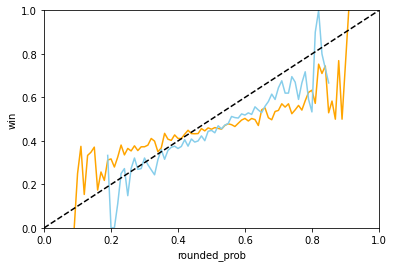

In [120]:
matchups['rounded_prob'] = round(matchups['win_probability'],2)
grouped_df = matchups.groupby('rounded_prob').mean().reset_index()

matchups['rounded_implied_odds'] = round(matchups['implied_odds_team'],2)
grouped_df_2 = matchups.groupby('rounded_implied_odds').mean().reset_index()


sns.lineplot(x="rounded_prob", y='win', data = grouped_df,color='orange')
sns.lineplot(x="rounded_implied_odds", y='win', data = grouped_df_2,color='skyblue')
plt.plot([0,1],[0,1], color='black', linestyle= 'dashed')
plt.xlim([0,1])
plt.ylim([0,1])

print(np.mean(matchups['implied_odds_team']))

In [121]:
# setting up dataframe with results only
metric_df = matchups.copy()
metric_df["binary_win_probability"] = round(metric_df['win_probability'], 0)

# drop null and inf values
metric_df = metric_df[metric_df.notnull().all(axis=1)]

# calculating standard metrics for lumpy awards
fpr, tpr, thresholds = roc_curve(
    metric_df["win"], metric_df["win_probability"], pos_label=True
)
areacurve = auc(fpr, tpr)
brierscorebinary = brier_score_loss(
    metric_df["win"], metric_df["win_probability"]
)
f1 = f1_score(
    metric_df["win"], metric_df["binary_win_probability"], average="weighted"
)
loglossbinary = log_loss(metric_df["win"], metric_df["win_probability"])
precision = precision_score(
    metric_df["win"], metric_df["binary_win_probability"], average="weighted"
)
recall = recall_score(
    metric_df["win"], metric_df["binary_win_probability"], average="weighted"
)

print('auc ',areacurve)
print('brier_score ',brierscorebinary)
print('f1_score ',f1)
print('log_loss ',loglossbinary)
print('precision ',precision)
print('recall ',recall)

auc  0.5626567914012635
brier_score  0.2530846169051582
f1_score  0.5425852269780533
log_loss  0.7009812291582289
precision  0.5455299798560909
recall  0.5416752164813067


In [123]:
# setting up dataframe with results only
metric_df = matchups.copy()
metric_df["binary_win_probability"] = round(metric_df['implied_odds_team'], 0)

# drop null and inf values
metric_df = metric_df[metric_df.notnull().all(axis=1)]

# calculating standard metrics for lumpy awards
fpr, tpr, thresholds = roc_curve(
    metric_df["win"], metric_df["implied_odds_team"], pos_label=True
)
areacurve = auc(fpr, tpr)
brierscorebinary = brier_score_loss(
    metric_df["win"], metric_df["implied_odds_team"]
)
f1 = f1_score(
    metric_df["win"], metric_df["binary_win_probability"], average="weighted"
)
loglossbinary = log_loss(metric_df["win"], metric_df["implied_odds_team"])
precision = precision_score(
    metric_df["win"], metric_df["binary_win_probability"], average="weighted"
)
recall = recall_score(
    metric_df["win"], metric_df["binary_win_probability"], average="weighted"
)

print('auc ',areacurve)
print('brier_score ',brierscorebinary)
print('f1_score ',f1)
print('log_loss ',loglossbinary)
print('precision ',precision)
print('recall ',recall)

auc  0.5894785030268881
brier_score  0.24567587499732968
f1_score  0.554057728658119
log_loss  0.684520828906459
precision  0.567521961297134
recall  0.5553412402019124
